# Deep Learning - Assignment 1
Names: François, Hanne; Ibragimova, Regina; Wieme, Xander

In [ ]:
# Update keras to version 3
!pip install --upgrade keras wandb --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.5/258.5 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.0.5 which is incompatible.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from tqdm import tqdm
from keras import Sequential, datasets, initializers, regularizers
from keras.layers import Flatten, Dense, Dropout, Input
from keras.optimizers import Adam, SGD, AdamW
from keras.utils import to_categorical, set_random_seed
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import ConfusionMatrixDisplay
import wandb

# Data loading and exploration
We have a Fashion-MNIST dataset which consists of a training set of 60 000 examples and a test set of 10 000 examples. We further split the train set of the dataset into a training and validation parts, the last is going to be used for hyperparameters tuning. After this we have 45 000 train samples, 15 000 validation samples, and 10 000 test samples.

In [ ]:
(x_train_all, y_train_all), (x_test, y_test) = datasets.fashion_mnist.load_data()
x_train, x_valid, y_train, y_valid = train_test_split(x_train_all, y_train_all, test_size=0.25)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


The dataset consists of clothing items images of 10 categories. We looked into examples of the data.

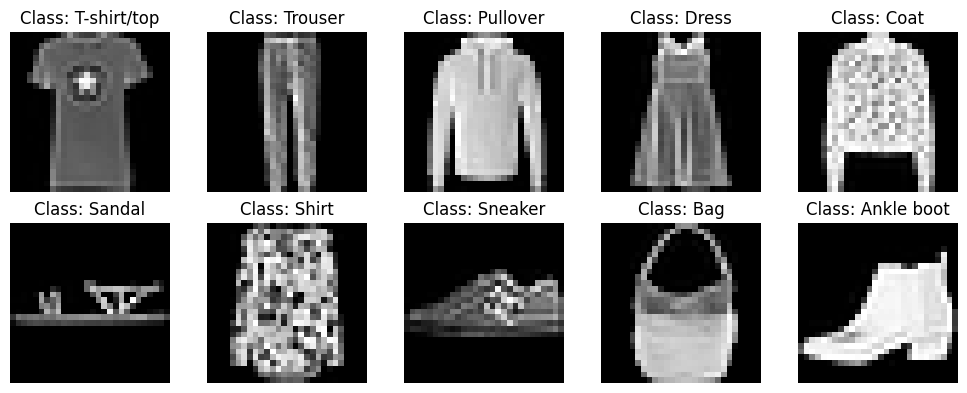

In [ ]:
class_labels = {0: "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
                5: "Sandal", 6:"Shirt", 7: "Sneaker", 8:"Bag", 9: "Ankle boot"}

fig = plt.figure(figsize=(10,4))

for i in range(10):
    plt.subplot(2,5,i+1)
    img = x_train[y_train == i][0]
    plt.imshow(img, cmap='gray', interpolation='none')
    plt.title("Class: {}".format(class_labels[i]))
    plt.axis('off')

plt.tight_layout()

# Data preprocessing
The current values fall inside this range:

In [ ]:
np.min(x_train), np.max(x_train)

(0, 255)

So, in a preprocessing step we normalized the values to ensure they all fall within the range of 0 to 1 by dividing each value by 255.

In [ ]:
x_train = x_train.astype("float32")
x_valid = x_valid.astype("float32")
x_test = x_test.astype("float32")

x_train /= 255
x_valid /= 255
x_test /= 255

We checked whether the values were between 0 and 1.

In [ ]:
np.min(x_train), np.max(x_train)

(0.0, 1.0)

Additionally, we encoded the outputs because we will be creating 10 output neurons (multi-class), each of which will provide an output that falls between 0 and 1.

In [ ]:
num_classes = 10

y_train = to_categorical(y_train, num_classes)
y_valid = to_categorical(y_valid, num_classes)
y_test = to_categorical(y_test, num_classes)

# Model definition

We created a function for a basic MLP model where the parameters had a default value and could be specified.

In [ ]:
def MLPModel(
    num_classes,
    lr=0.01,
    n_hidden_layers=2,
    n_units=8,
    act_f='relu',
    opt=Adam,
    l2=0.0,
    dropout_rate=0.0
):

  model = Sequential()
  model.add(Input(shape=(28, 28)))
  model.add(Flatten())

  for _ in range(n_hidden_layers):
      model.add(
        Dense(
          n_units,
          activation=act_f,
          kernel_regularizer=regularizers.L2(l2)
        )
      )

      if dropout_rate > 0:
        model.add(Dropout(dropout_rate))

  model.add(Dense(num_classes, activation='softmax'))
  optimizer = opt(learning_rate=lr)
  model.compile(
      loss='categorical_crossentropy',
      optimizer=optimizer,
      metrics=['accuracy']
  )

  return model

where:

*   lr is the chosen learning rate
*   n_hidden_layers is the chosen number of hidden layers
*   n_units is the chosen number of units
*   act_f is the chosen activation function
*   opt is the chosen optimiser
*   droputout_rate is the chosen rate for dropout
*   l2 is the chosen value for weight decay


Next, we defined functions to be used later for graphs plotting, tables creation, and training our models.

In [ ]:
def plot_histories(histories, varname, metric="val_accuracy") -> None:
  """
  Plot metric value for the given histories in function of epochs.

  :param histories: dictionairy of pandas dataframes containing history of the
    training as values and variable value as keys
  :param varname: variable name changed over the different histories
  :param metric: which metric of the history that should be plotted
    (default is val_accuracy)
  """
  fig = go.Figure()

  for varvalue, df in histories.items():
      fig.add_trace(
          go.Scatter(y=df["val_accuracy"], name=varvalue)
      )

  fig.update_layout(
      autosize=False,
      width=800,
      height=500,
      xaxis_title="Epoch",
      yaxis_title=metric,
      legend_title=varname,
      margin={"l": 10, "t": 10, "r": 10, "b": 10},
      template="plotly_white"
  )
  fig.show()

In [ ]:
def create_table(histories, varname) -> None:
  """
  Create table of the accuracy in function of variable
  """

  history_df = pd.concat(histories, ignore_index=True)

  assert varname in history_df.columns

  display(
      history_df.groupby(varname)\
      [["accuracy", "val_accuracy"]].max()\
      .rename(columns={"accuracy": "train_accuracy"})
      .style.background_gradient()
  )

In [ ]:
def iterate(varname: str, values: list, config: dict) -> dict():
    """
    Train different MLP models while changing a given hyperparameter of
    the supplied values.

    :param varname: name of the hyperparameter, e.g. lr
    :param values: list of hyperparameter values
    :param config: MLP configuration as a dict
    """

    histories = {}
    config = config.copy()

    # Display progressbar during iteration
    for value in tqdm(values):

      # Change hyperparameter value
      config[varname] = value

      model = MLPModel(
          config["num_classes"],
          config["lr"],
          config["n_hidden_layers"],
          config["n_units"],
          act_f=config["activation"],
          opt=config["optimizer"]
      )

      early_stopping_monitor = EarlyStopping(patience=config["patience"])

      history = model.fit(
          x_train,
          y_train,
          batch_size=config["batch_size"],
          epochs=config["epochs"],
          verbose=0,
          validation_data=(x_valid, y_valid),
          callbacks=[early_stopping_monitor]
      )

      # Convert history to pandas data frame and add to dictionary
      df = pd.DataFrame(history.history)
      df[varname] = value
      histories[value] = df

    return histories

# Training the model

We defined a configuration dictionary (**config**) to store hyperparameters, which can be updated as better values are found during the hyperparameters tuning process. We choose a patience of 10, meaning that if the model's performance does not improve for 10 consecutive epochs, training will stop early. Using all these parameters, we trained our initial model with shuffling (which is true by default).  

In [ ]:
# configuration dictionary
config = {
    "num_classes": 10,
    "epochs": 30,
    "batch_size": 128,
    "patience": 10,
    "lr": 0.01,
    "n_hidden_layers": 2,
    "n_units": 8,
    "activation": "relu",
    "optimizer": Adam,
}

# initiating the mdoel
model = MLPModel(
    config["num_classes"],
    config["lr"],
    config["n_hidden_layers"],
    config["n_units"],
    act_f=config["activation"],
    opt=config["optimizer"]
)

# early stopping configuration
early_stopping_monitor = EarlyStopping(patience=10)
history = model.fit(
    x_train, y_train,
    batch_size=config["batch_size"],
    epochs=config["epochs"],
    verbose=0,
    validation_data=(x_valid, y_valid),
    callbacks=[early_stopping_monitor])

# Evaluating the starting model

In [ ]:
score_train = model.evaluate(x_train, y_train, verbose=0)
score_valid = model.evaluate(x_valid, y_valid, verbose=0)

print("Train loss:          {:7.2f}".format(score_train[0]))
print("Train accuracy:      {:7.2f}".format(score_train[1]))
print("Validation loss:     {:7.2f}".format(score_valid[0]))
print("Validation accuracy: {:7.2f}".format(score_valid[1]))

Train loss:             0.47
Train accuracy:         0.84
Validation loss:        0.53
Validation accuracy:    0.82


Our starting model (model with defined default values) had a training and validation accuracy of 0.84 and 0.82, respectively.

# Hyperparameter tuning
In order to improve the performance of our model, we optimized the hyperparameters. For this we tried the following options:

- learning rate: 1e-4, 1e-3, 1e-2
- optimizer: Adam, AdamW, SGD
- activation function: ReLU, leaky ReLU, sigmoid, tanh, GeLU
- number of hidden layers: 2, 3, 4, 5, 6
- number of hidden units per layer: 8, 16, 32, 64, 128, 256, 512, 1024
- dropout: 0.0, 0.01, 0.05, 0.1, 0.2
- regularization L2: 0.0, 0.01, 0.05, 0.1, 0.2



For the loss function, we chose categorical crossentropy, considering it the optimal choice for this task. We maintained a batch size of 128 and fine-tuned the parameters accordingly.
First, we optimized the learning rate.

## Learning rate

We tried the learning rates 0.0001, 0.001, and 0.01 to improve our model's accuracy.

In [ ]:
lr_to_test = [1e-4, 1e-3, 1e-2]
histories = iterate('lr', lr_to_test, config)

100%|██████████| 3/3 [02:10<00:00, 43.35s/it]


In [ ]:
# plot the validation accuracry of possible learning values
plot_histories(histories, 'lr')
# create a table with maximum train accuracy (left) and maximum validation accuracy (right)
create_table(histories, 'lr')

,train_accuracy,val_accuracy
lr,,
0.000100,0.835778,0.833533
0.001000,0.867222,0.857133
0.010000,0.783311,0.774867


It was found that the learning rate of 0.001 resulted in the highest validation accuracy without overfitting, as indicated by the steady and plateauing accuracy curve on the graph and a validation accuracy close to the training accuracy. We will use these same reasonings to check overfitting for the other hyperparameters as well. This learning rate of 0.001 represents an optimal balance, avoiding the slow convergence associated with lower rates and the potential instability of higher rates. So, we set the learning rate to 0.001 to improve the model's performance.

In [ ]:
# changed lr: 0.01 => 0.001
config["lr"] = 0.001

## Optimizers

We tried the optimizers Adam, AdamW, and SGD to improve our model's accuracy.

In [ ]:
optimizers_to_test = [Adam, AdamW, SGD]
histories = iterate('optimizer', optimizers_to_test, config)

100%|██████████| 3/3 [02:07<00:00, 42.46s/it]


In [ ]:
histories = dict(zip(['adam', 'adamw', 'sgd'], histories.values()))

In [ ]:
for k in ['adam', 'adamw', 'sgd']:
  histories[k]['optimizer'] = k

In [ ]:
plot_histories(histories, 'optimizer')
create_table(histories, 'optimizer')

,train_accuracy,val_accuracy
optimizer,,
adam,0.870333,0.859267
adamw,0.866178,0.855400
sgd,0.735756,0.742667


The plotted curves showed that the Adam optimizer outperformed SGD and AdamW in terms of validation accuracy and convergence speed. There are no signs of overfitting. For these reasons, the optimizer was chosen.

## Number of hidden layers

We tried 2, 3, 4, 5, 6 number of hidden layers to improve our model's accuracy because extra layers might allow the model to identify more complex patterns in the dataset.

In [ ]:
n_hidden_layers_to_test = [2, 3, 4, 5, 6]
histories = iterate('n_hidden_layers', n_hidden_layers_to_test, config)

100%|██████████| 5/5 [03:50<00:00, 46.14s/it]


In [ ]:
plot_histories(histories, "n_hidden_layers")
create_table(histories, "n_hidden_layers")

,train_accuracy,val_accuracy
n_hidden_layers,,
2,0.868356,0.857600
3,0.864600,0.851600
4,0.855289,0.843333
5,0.865778,0.851867
6,0.850778,0.838333


It can be seen that the increasing the number of hidden layers does not help to improve the performance and there are no signs of overfitting, so we kept it at 2 hidden layers.

## Number of units

We tried 8, 16, 32, 64, 128, 256, 512, 1014 for numbers of units to improve our model's accuracy.

In [ ]:
n_units_to_test = [8, 16, 32, 64, 128, 256, 512, 1024]
histories = iterate('n_units', n_units_to_test, config)

100%|██████████| 8/8 [17:01<00:00, 127.67s/it]


In [ ]:
plot_histories(histories, "n_units")
create_table(histories, "n_units")

,train_accuracy,val_accuracy
n_units,,
8,0.865867,0.855533
16,0.895533,0.878800
32,0.911956,0.882533
64,0.930444,0.889800
128,0.935978,0.894667
256,0.943067,0.896867
512,0.944044,0.901467
1024,0.952067,0.900333


Based on the high validation accuracy and because of computational complexity and lower overfitting risk, we set the number of hidden units to 128 to improve the model's performance.

In [ ]:
# changed n_units: 8 => 128
config["n_units"] = 128

## Number of hidden layers for specified units

The number of hidden layers is reexamined again because this can have changed after using different number of units in the layers.

In [ ]:
n_hidden_layers_to_test = [2, 3, 4, 5, 6]
histories = iterate('n_hidden_layers', n_hidden_layers_to_test, config)

100%|██████████| 5/5 [06:05<00:00, 73.20s/it]


In [ ]:
plot_histories(histories, "n_hidden_layers")
create_table(histories, "n_hidden_layers")

,train_accuracy,val_accuracy
n_hidden_layers,,
2,0.937400,0.897667
3,0.933067,0.894200
4,0.925200,0.891467
5,0.924911,0.892600
6,0.936933,0.896733


The optimal accuracy is still obtained with 2 hidden layers after changing the number of units to 128.

## Activation function

We tried the activation functions ReLU, leaky ReLU, sigmoid, tanh, and GeLU to improve our model's accuracy

In [ ]:
act_f_to_test = ["relu", "leaky_relu", "sigmoid", "tanh", "gelu"]
histories = iterate("activation", act_f_to_test, config)

100%|██████████| 5/5 [05:35<00:00, 67.15s/it]


In [ ]:
plot_histories(histories, "activation")
create_table(histories, "activation")

,train_accuracy,val_accuracy
activation,,
gelu,0.939689,0.894667
leaky_relu,0.935711,0.893067
relu,0.934600,0.896133
sigmoid,0.934644,0.893733
tanh,0.943711,0.895467


Based on the results, changing the activation function does not improve the validation accuracy. The activation function used further on is ReLU.





## Dropout

Although we saw no sign of overfitting, we tried the dropout values 0.0, 0.01, 0.05, 0.1, and 0.2 to see if this was necassary to incorporate.

In [ ]:
dropout_values = [0.0, 0.01, 0.05, 0.1, 0.2]
histories = iterate("dropout_rate", dropout_values, config)

100%|██████████| 5/5 [05:21<00:00, 64.35s/it]


In [ ]:
plot_histories(histories, "dropout_rate")
create_table(histories, "dropout_rate")

,train_accuracy,val_accuracy
dropout_rate,,
0.000000,0.945000,0.896533
0.010000,0.934156,0.896267
0.050000,0.934600,0.893600
0.100000,0.931489,0.894600
0.200000,0.938511,0.895000


Based on the obtained results, dropout does not improve the validation accuracy, perhaps due to the relative small model architecture.

## Regularization

Lastly, we tried whether weight decay was needed for our model.

In [ ]:
l2_values = [0.0, 0.01, 0.05, 0.1, 0.2]
histories = iterate("l2_values", l2_values, config)

100%|██████████| 5/5 [05:07<00:00, 61.44s/it]


In [ ]:
plot_histories(histories, "l2_values")
create_table(histories, "l2_values")

,train_accuracy,val_accuracy
l2_values,,
0.000000,0.944178,0.895000
0.010000,0.928867,0.891667
0.050000,0.939778,0.896733
0.100000,0.939400,0.894133
0.200000,0.937511,0.894933


Adding L2 regularization does not improve the validation accuracy significantly, which can be explained by the relative small model architecture.

## Random search

We also tried a different approach with random search. This approach randomly arranges the hyperparameters provided (see sweep_configuration in the code below) and uses them for the model training. We used the Weights & Biases MLOps platform for this purpose. Below you can see the page with the results.

In [ ]:
# Set up wandb
wandb.login()

optimizers = {
    "Adam": Adam,
    "AdamW": AdamW,
    "SGD": SGD,
}

def objective(config) -> pd.DataFrame:
  """
  Create a MLP with given model and train it.
  """

  model = MLPModel(
      config["num_classes"],
      config["lr"],
      config["num_hidden_layers"],
      config["num_hidden_units"],
      config["act_f"],
      optimizers[config["optimizer"]]
  )
  early_stopping_monitor = EarlyStopping(patience=config["patience"])

  history = model.fit(
    x_train,
    y_train,
    batch_size=config["batch_size"],
    epochs=config["epochs"],
    verbose=0,
    validation_data=(x_test, y_test),
    callbacks=[early_stopping_monitor]
  )

  df = pd.DataFrame(history.history)

  return df


def optimize():
    """
    Function used by wandb to log model training history
    """
    wandb.init(project="DeepLearningAssignment1")
    metrics = objective(wandb.config)
    metrics.apply(lambda row: wandb.log(row.to_dict()), axis=1)


# Define the search space
sweep_configuration = {
    "method": "random",
    "metric": {"goal": "minimize", "name": "val_loss"},
    "parameters": {
        "lr": {"max": 0.1, "min": 0.001},
        "num_hidden_layers": {"values": [2, 4, 6, 8]},
        "num_hidden_units": {"values": [8, 16, 32, 64, 128, 256, 512, 1024]},
        "optimizer": {"values": ["Adam", "AdamW", "SGD"]},
        "act_f": {"values": ["relu", "leaky_relu", "selu", "gelu", "tanh", "sigmoid"]},
        "l2": {"max": 0.5, "min": 0.0},
        "dropout_rate": {"max": 0.5, "min": 0.0},
        "batch_size": {"value": 128},  ######## should this not be 128?
        "epochs": {"value": 100},
        "num_classes": {"value": 10},
        "patience": {"value": 5},
    },
}

# Start sweep
sweep_id = wandb.sweep(sweep=sweep_configuration, project="DeepLearningAssignment1")
wandb.agent(sweep_id, function=optimize, count=25)
wandb.finish()

In [ ]:
api = wandb.Api()
sweep = api.sweep("mlchem/DeepLearningAssignment1/xcjuflue")
sweep.display(height=720)

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
/usr/local/lib/python3.10/dist-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


True

The random search did not find a better model than the current manual tuned model.

# Final model

The final configuration for our model is as follows:
*   learning rate = 0.001
*   optimizer = Adam
*   number of hidden layers = 2
*   number of units per layer = 128
*   activation function = ReLU
*   No dropout layer
*   No L2 regularization





In [ ]:
model_final = MLPModel(
    num_classes,
    lr=0.001,
    n_hidden_layers=2,
    n_units=128,
    act_f='relu',
    opt=Adam
)

model_final.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 118,282 (462.04 KB)

 Trainable params: 118,282 (462.04 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# fit our final model on our training dataset
history_final = model_final.fit(
    x_train, y_train,
    batch_size=config["batch_size"],
    epochs=config["epochs"],
    verbose=0,
    validation_data=(x_valid, y_valid),
    callbacks=[early_stopping_monitor]
)

In [ ]:
# Convert history_final to dataframe for plotting progress
df = pd.DataFrame(history_final.history)

fig = make_subplots(cols=2, x_title="Epoch")

fig.add_trace(
    go.Scatter(
        y=df.accuracy, line={"color": "#1f77b4"}, name="Train", legendgroup=1
    ),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(
        y=df.val_accuracy,
        line={"color": "#ff7f0e"},
        name="Validation",
        legendgroup=2
    ),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(
        y=df.loss,
        line={"color": "#1f77b4"},
        name="Train",
        showlegend=False,
        legendgroup=1
      ),
    row=1, col=2
)
fig.add_trace(
    go.Scatter(
        y=df.val_loss,
        line={"color": "#ff7f0e"},
        name="Validation",
        showlegend=False,
        legendgroup=2
    ),
    row=1, col=2
)

# Edit y axis titles
fig['layout']['yaxis']['title']='Accuracy'
fig['layout']['yaxis2']['title']='Loss'

fig.update_layout(
    autosize=False,
    width=1500,
    height=500,
    template="seaborn",
)

fig.show()

In [ ]:
# calculating train, validation, and test loss and accuracy of our final model
score_final_train = model_final.evaluate(x_train, y_train, verbose=0)
score_final_valid = model_final.evaluate(x_valid, y_valid, verbose=0)
score_final_test = model_final.evaluate(x_test, y_test, verbose=0)

print("Train loss of the final model:         {:7.2f}".format(score_final_train[0]))
print("Train accuracy of the final model:     {:7.2f}".format(score_final_train[1]))
print("Validation loss of the final model:    {:7.2f}".format(score_final_valid[0]))
print("Validation accuracy of the final model:{:7.2f}".format(score_final_valid[1]))
print("Test loss of the final model:          {:7.2f}".format(score_final_test[0]))
print("Test accuracy of the final model:      {:7.2f}".format(score_final_test[1]))

Train loss of the final model:            0.24
Train accuracy of the final model:        0.91
Validation loss of the final model:       0.32
Validation accuracy of the final model:   0.89
Test loss of the final model:             0.34
Test accuracy of the final model:         0.88


In summary, our final model demonstrated consistent performance on the training, validation, and test datasets, achieving accuracies of 0.91, 0.89, and 0.88, respectively. These accuracy scores across all datasets and the graphs indicate that our final model shows no sign of overfitting.

# Evaluating the Robustness of the Model to Image Transformations

Next, we checked if our model could deal with rotated images. For this we used our test dataset.

In [ ]:
# rotating the images of the test dataset
x_test_rotated = np.flip(x_test, (1, 2))

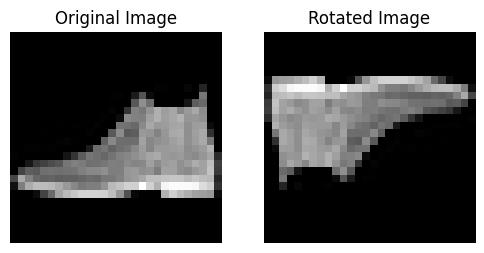

In [ ]:
plt.figure(figsize=(6, 3))

# plot an original image of the test dataset
plt.subplot(1, 2, 1)
plt.imshow(x_test[0], cmap="gray")
plt.title('Original Image')
plt.axis('off');

# plot the image of the test dataset rotated
plt.subplot(1, 2, 2)
plt.imshow(x_test_rotated[0], cmap="gray")
plt.title('Rotated Image')
plt.axis('off');

In [ ]:
# calculating loss and accuracy for the rotated test dataset
score_rotated = model_final.evaluate(x_test_rotated, y_test, verbose=0)

print("Test loss for rotated images:      {:7.2f}".format(score_rotated[0]))
print("Test accuracy for rotated images:  {:7.2f}".format(score_rotated[1]))

Test loss for rotated images:         7.20
Test accuracy for rotated images:     0.19


It can be seen that the model's accuracy significantly dropped to 0.19. It may be because the model has learned dataset-specific patterns, particularly those unique to different classes (such as the sole down and the toe on the left for shoes).

In [ ]:
# Initialize the ImageDataGenerator with a zoom_range for zoom-in and out effects
datagen_in = ImageDataGenerator(zoom_range=(0.6, 0.6))
datagen_out = ImageDataGenerator(zoom_range=(1.6, 1.6))

# Reshape the dataset to include the channel dimension
x_test_reshaped = x_test.reshape(10000, 28, 28, 1)

x_test_zoomed_in = np.zeros_like(x_test_reshaped)
x_test_zoomed_out = np.zeros_like(x_test_reshaped)

# Apply the transformation to each image
for i in range(len(x_test_reshaped)):
    x_test_zoomed_in[i] = datagen_in.random_transform(x_test_reshaped[i])
    x_test_zoomed_out[i] = datagen_out.random_transform(x_test_reshaped[i])

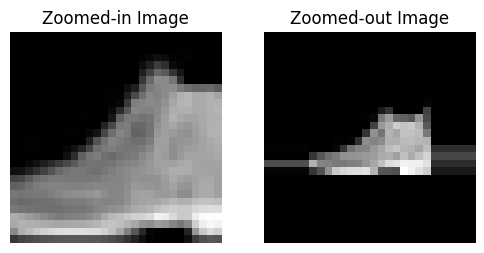

In [ ]:
plt.figure(figsize=(6, 3))

# plot the zoomed-in image
plt.subplot(1, 2, 1)
plt.imshow(x_test_zoomed_in[0].squeeze(), cmap='gray')
plt.title('Zoomed-in Image')
plt.axis('off');

# plot the zoomed-out image
plt.subplot(1, 2, 2)
plt.imshow(x_test_zoomed_out[0].squeeze(), cmap="gray")
plt.title('Zoomed-out Image')
plt.axis('off');

In [ ]:
# calculating loss and accuracy for zoomed-in and zoomed-out images
score_zoomed_in = model_final.evaluate(x_test_zoomed_in.squeeze(), y_test, verbose=0)
score_zoomed_out = model_final.evaluate(x_test_zoomed_out.squeeze(), y_test, verbose=0)
print("Test loss for zoomed-in images:      {:7.2f}".format(score_zoomed_in[0]))
print("Test accuracy for zoomed-in images:  {:7.2f}".format(score_zoomed_in[1]))
print("Test loss for zoomed-out images:     {:7.2f}".format(score_zoomed_out[0]))
print("Test accuracy for zoomed-out images: {:7.2f}".format(score_zoomed_out[1]))

Test loss for zoomed-in images:         7.42
Test accuracy for zoomed-in images:     0.35
Test loss for zoomed-out images:        1.87
Test accuracy for zoomed-out images:    0.45


Our trained model faces challenges in accurately classifying images at different scales, indicated by the notably low test accuracy values of 0.35 and 0.45, respectively.
To sum up, our MLP model encounters difficulties in accurately classifying images that are either rotated or vary in scale. This mainly comes from the fact that MLP's design does not have handles such as weight sharing and pooling seen in convolutional neural networks (CNNs), making it unable to reacting to variations in input.

# Analyzing Model Predictions

Next, we investigated areas of weakness or need for improvement based on what our model was most satisfied  or concerned about.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


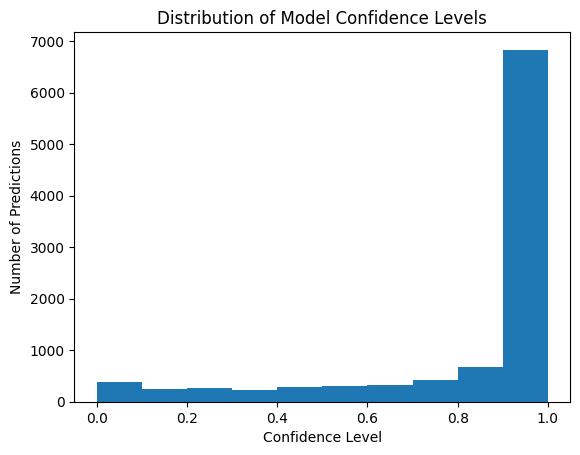

In [ ]:
preds = model_final.predict(x_test)

preds_probs = preds[range(10000), y_test.argmax(axis=1)]
plt.hist(preds_probs)
plt.xlabel('Confidence Level')
plt.ylabel('Number of Predictions')
plt.title('Distribution of Model Confidence Levels');

The vast majority of predictions cluster near 1 at the high confidence level, indicating that the model is quite confident in its predictions for the majority of test samples. However, there are few test samples for which the model is less certain. Next, we determined for which classes the model was less certain.

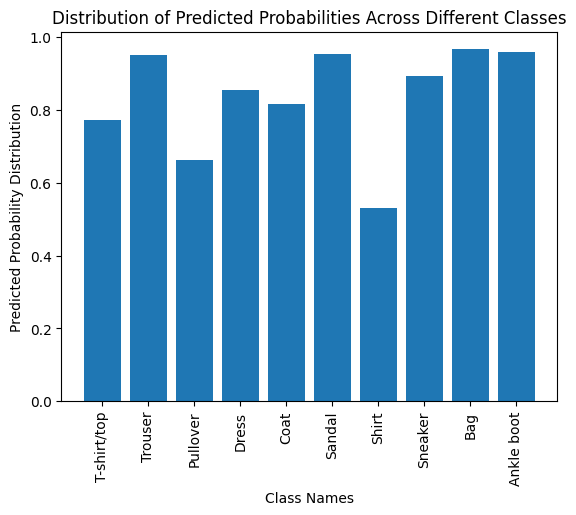

In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# distribution of predicted probabilities across different class labels
bc = np.bincount(y_test.argmax(axis=1),
                 weights = preds_probs) / np.bincount(y_test.argmax(axis=1))
plt.bar(range(10), bc)
plt.xticks(range(10), class_names, rotation='vertical')

plt.xlabel('Class Names')
plt.ylabel('Predicted Probability Distribution')
plt.title('Distribution of Predicted Probabilities Across Different Classes')

plt.show()

Our final model was most confident about the pictures of the Trouser, Sandal, Sneaker, Bag, and Ankle boot classes.The most confusing pictures were in classes Shirt, T-shirt/top, Pullover, Coat. This can be explained by the fact that pullovers, coats, T-shirts/tops, and shirts all have similar fundamental shapes and outlines, so it is hard for the model to recognise them apart, especially when details that could indicate which type of clothing items are not clear because of low resolution. This problem is made worse by the absence of colour and texture characteristics in grayscale photos, which are frequently crucial distinctions between these kinds of clothes in actual settings.

We also determined the percentage of correctly and incorrectly classified items:

In [ ]:
pred_arg = np.argmax(preds, axis=1)
y_test_arg = np.argmax(y_test, axis=1)

# identifying correctly and incorrectly images
correct_indices = np.nonzero(pred_arg == y_test_arg)[0]
incorrect_indices = np.nonzero(pred_arg != y_test_arg)[0]

ci = len(correct_indices)
ii = len(incorrect_indices)
print('Correctly classified items  : {:5d} ({:=5.2f} %)'.format(ci, ci * 100 / (ci + ii)))
print('Incorrectly classified items: {:5d} ({:=5.2f} %)'.format(ii, ii * 100 / (ci + ii)))

Correctly classified items  :  8770 (87.70 %)
Incorrectly classified items:  1230 (12.30 %)


Our model correctly classifies 87.70% of the test images and incorrectly classifies 12.30% of the test images.

We created a confusion matrix to see which categories our model confuses with other categories.

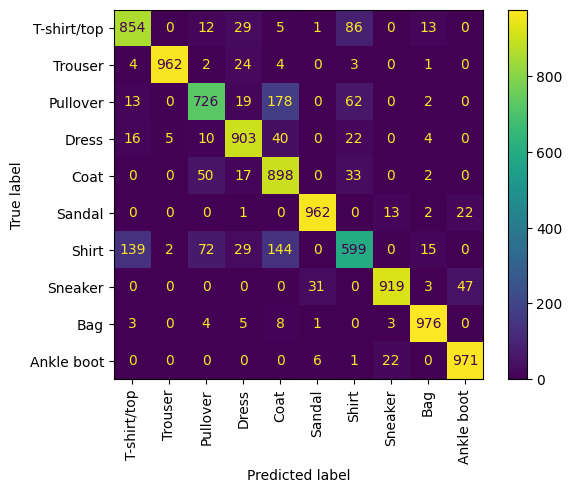

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test_arg,
                                        pred_arg,
                                        display_labels=class_names,
                                        xticks_rotation = "vertical");

This confusion matrix is 10 by 10 with one row and one column for each class. The diagonal shows the accurate predictions, whereas the number of items that have been wrongly classified is shown outside of the diagonal. The confusion matrix also reveals that shirts have the highest rate of misclassification within the model's predictions. There is a notable tendency for the model to confuse shirts with T-shirts/tops, and this error occurs in both directions. The model also confuses shirts with coats. The model also misclassifies pullovers as coats. While these constitute the primary areas of confusion, other categories experience misclassification less commonly. To gain insight, we visualized examples from our dataset that the model predicted incorrectly.

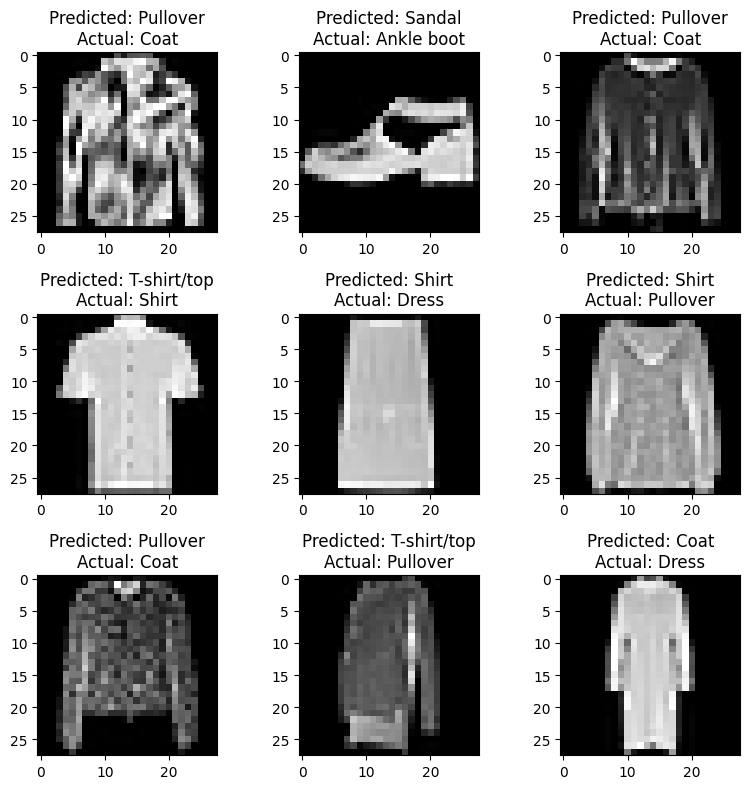

In [ ]:
# plot examples for incorrectly identified images
plt.figure(figsize=(8,8))
for i, incorrect in enumerate(incorrect_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(x_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')

    predicted_label = class_labels[pred_arg[incorrect]]
    actual_label = class_labels[y_test_arg[incorrect]]
    plt.title(f"Predicted: {predicted_label}\nActual: {actual_label}")

plt.tight_layout()


Upon closer inspection, we can see the rationale behind the model's misclassifications. For example, in the cases where the model misidentified a coat as a pullover, it makes sense because coats and pullovers may have comparable characteristics. Another one is where the model predicts a coat when the true lable is dress, this is because long coats share common features with desses. The ankle boot that is misclassifies as a sandle also shows where the model has pittfals. The misclassification happens mainly because of the black area inside the picture of the ankle boot, misleading the model into thinking it isn't a closed shoe.

To sum up, our model does well when it comes to recognising distinct clothing items, however it has difficulties with classes like T-shirts, Pullovers, Shirts, and Coats that have similar outlines in grayscale photos. This leads to the most frequent misclassifications occuring when two items have similar features.
To improve the performance of the model, incorporating data augmentation strategies and expanding the dataset with additional images for the challenging classes can be beneficial.